## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Мещанинов Вячеслав Павлович

In [28]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
from torch.nn import ReLU
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [22]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

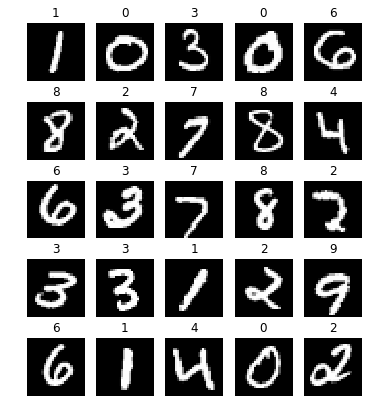

In [10]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [5]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [6]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [27]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

def HE(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0])
    weight.normal_(mean=0, std=np.sqrt(d))


In [41]:
def show_opt(init_f):
    init_f = xavier_init_uni

    net = []
    net.append(make_linear(28*28, 500, init_f))
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
    net.append(make_linear(500, 10, init_f))
    net = nn.Sequential(*net)

    #пример:
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [42]:
show_opt(xavier_init_uni)

forward 1.0023102760314941
forward 1.1037665605545044
forward 1.1226216554641724
forward 1.1348069906234741
forward 1.1259390115737915
forward 1.1307628154754639
forward 1.1231402158737183
forward 1.1243773698806763
forward 1.1410468816757202
forward 1.1420232057571411
backward 0.03590109571814537
backward 0.02096344158053398
backward 0.02110152132809162
backward 0.02293957956135273
backward 0.022798918187618256
backward 0.02252284064888954
backward 0.02249479852616787
backward 0.024025551974773407
backward 0.024171557277441025
backward 0.024871448054909706


In [43]:
show_opt(xavier_init)

forward 1.0023102760314941
forward 1.099372148513794
forward 1.0910412073135376
forward 1.0867078304290771
forward 1.0885400772094727
forward 1.085909366607666
forward 1.0823338031768799
forward 1.0800087451934814
forward 1.0769776105880737
forward 1.0739330053329468
backward 0.03590109571814537
backward 0.02074240706861019
backward 0.02096439152956009
backward 0.02051498182117939
backward 0.01943323388695717
backward 0.018813440576195717
backward 0.01934533752501011
backward 0.019749030470848083
backward 0.01943252794444561
backward 0.018610399216413498


In [44]:
show_opt(HE)

forward 1.0023102760314941
forward 1.1123322248458862
forward 1.0979058742523193
forward 1.110722303390503
forward 1.107648253440857
forward 1.1040271520614624
forward 1.1065794229507446
forward 1.1145145893096924
forward 1.1331536769866943
forward 1.1448081731796265
backward 0.03590109571814537
backward 0.02048983797430992
backward 0.020769506692886353
backward 0.021152326837182045
backward 0.02216021902859211
backward 0.021515749394893646
backward 0.020714614540338516
backward 0.01964954473078251
backward 0.018275802955031395
backward 0.01806982420384884


<i> 1.4 Сделайте выводы по первой части </i>

### Xavier_init
------
Идея этого метода заключается в том, чтобы обеспечить стабильность дисперсии при переходе от одного слоя к дургому. Это позволяет сдерживать сигнал от слишком большого роста, и от падения до нуля. Поэтому мы должны выбирать веса с нормальным распределением, нулевым мат ожиданием и дисперсией равной 1/N.

----

Метод инициализации He — это частный случай метода Хавьера, больше подходящий функции активации ReLU, компенсирующий тот факт, что эта функция возвращает нуль для половины области определения

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [17]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.620/0.332	Accuracy: 0.841/0.920


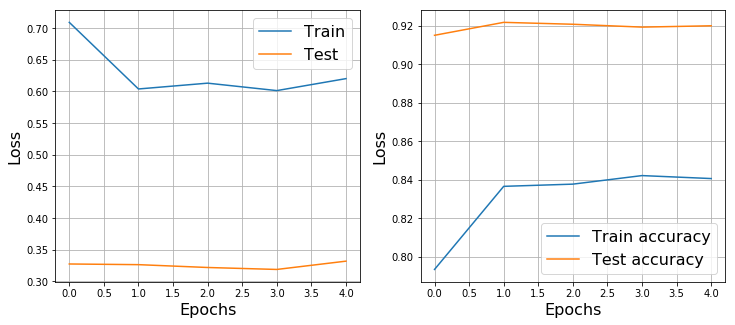

([0.7089549429508161,
  0.6037019389524643,
  0.6128822518691325,
  0.6011336360023474,
  0.6200466527740585],
 [0.3271805349784561,
  0.32612312160715273,
  0.32163816105715837,
  0.3185496094483363,
  0.33165043158621726],
 [0.79340464, 0.83657604, 0.8377254, 0.8421675, 0.84062386],
 [0.9150514, 0.9217761, 0.92078716, 0.9193038, 0.919996])

In [19]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

In [25]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.265/0.140	Accuracy: 0.929/0.962


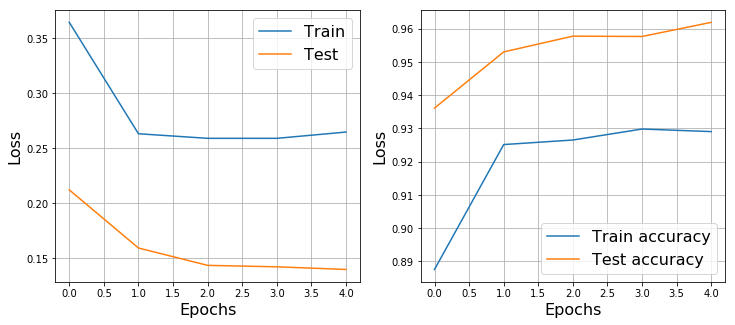

([0.36415748457029173,
  0.2629810358320218,
  0.25882933877392617,
  0.25881942327438134,
  0.26452056370945626],
 [0.21201290548602236,
  0.1592307031343255,
  0.1434563718252827,
  0.1421301029150999,
  0.13974341382331487],
 [0.8875378, 0.9251344, 0.92650586, 0.92980963, 0.92903787],
 [0.9361155, 0.9530261, 0.957773, 0.957674, 0.9619264])

In [26]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

### DropOut
---
Идея этого метода заключается в том, что чтобы избежать переобучения, мы будем занулять выходные слои некоторых нейронов с вероятностью p. Замечу, что наш алгоритм также хорошо работает на тесте, как и на трейне. Сл-но, переобучения нет.

----
### DropConnection
----
Цель та же самая, что и в DropOut, но здесь мы будем занулять веса с какой-то вероятностью.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [89]:
# полезные функции: .std(dim), .mean(dim)
eps = 0.001
class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(1).repeat(x.size()[1], 1).T) / (x.std(1).repeat(x.size()[1], 1).T + eps)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [102]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.BatchNorm1d(out_dim, out_dim, affine=False))
    net.append(nn.ReLU())

net.append(nn.Linear(sizes[-1], 10))
net.append(nn.BatchNorm1d(10, 10, affine=False)) ## будем юзать batch normalisation без доп параметров, то есть без гаммы и бетты
net.append(nn.LogSoftmax(1))

net = nn.Sequential(*net)

Epoch 9... (Train/Test) NLL: 0.361/0.348	Accuracy: 0.992/0.985


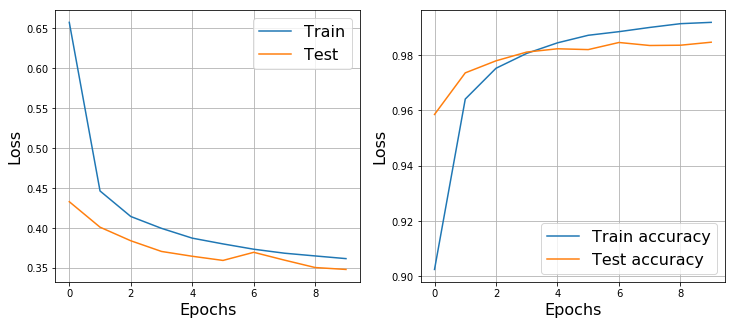

([0.6575361904559105,
  0.44622723189498315,
  0.4142340934479923,
  0.3993680010091013,
  0.3870834847376036,
  0.3798681500751072,
  0.3732111013011892,
  0.3682214883344768,
  0.36478089294962285,
  0.36143234334012336],
 [0.43276904127265836,
  0.4008213330673266,
  0.3838223694246026,
  0.3704170509229732,
  0.3643854690503471,
  0.35916533500333375,
  0.3693306076375744,
  0.35953269691406925,
  0.35023998874652235,
  0.3478647836401493],
 [0.9024465,
  0.9640247,
  0.97515774,
  0.9805382,
  0.9843472,
  0.9870791,
  0.988384,
  0.9899109,
  0.9912713,
  0.99174887],
 [0.9584652,
  0.97349685,
  0.9778481,
  0.98101264,
  0.9821994,
  0.9819027,
  0.9844739,
  0.9833861,
  0.983485,
  0.98457277])

In [103]:
train(net, train_loader, test_loader, 10, 0.01, device='cpu')

In [96]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(LayerNormalization())
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(LayerNormalization())
net.append(nn.LogSoftmax(1))

net = nn.Sequential(*net)

Epoch 9... (Train/Test) NLL: 0.354/0.382	Accuracy: 0.990/0.978


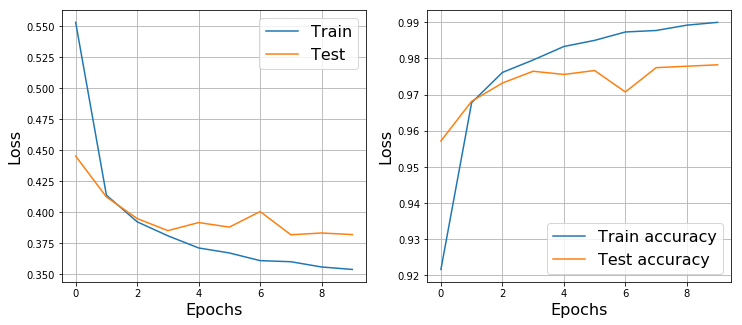

([0.5532475671153079,
  0.41399358419467136,
  0.39246981046093043,
  0.3811777975640571,
  0.371400301517454,
  0.3673593440035513,
  0.3611703342847478,
  0.3602924252242676,
  0.35605346203358695,
  0.35406812631499285],
 [0.44546544966818413,
  0.4125078788286523,
  0.39507743489893177,
  0.38535395076003254,
  0.391859921473491,
  0.3882046432434758,
  0.40074381269986115,
  0.3820266025730326,
  0.38344708877273753,
  0.38219396034373515],
 [0.921664,
  0.9677727,
  0.9761294,
  0.979572,
  0.98330337,
  0.98499686,
  0.9873179,
  0.9877288,
  0.98920023,
  0.98997754],
 [0.9571796,
  0.96815664,
  0.97320014,
  0.9764636,
  0.9755736,
  0.9766614,
  0.97072786,
  0.9774525,
  0.9778481,
  0.97824365])

In [97]:
train(net, train_loader, test_loader, 10, 0.01, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: